In [ ]:
import pandas as pd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import importlib
import gpudrive
importlib.reload(gpudrive)

import numpy as np
import os
import torch
from pathlib import Path

# Set working directory to the base directory 'gpudrive_madrona'
working_dir = Path.cwd()
while working_dir.name != 'gpudrive':|
    working_dir = working_dir.parent
    if working_dir == Path.home():
        raise FileNotFoundError("Base directory 'gpudrive_madrona' not found")
os.chdir(working_dir)
import torch
from PIL import Image
import seaborn as sns
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime

from gpudrive.env.env_torch import GPUDriveTorchEnv
from gpudrive.env.config import EnvConfig, RenderConfig
from gpudrive.env.dataset import SceneDataLoader
from gpudrive.visualize.utils import img_from_fig

sns.set("notebook", font_scale=1.05, rc={"figure.figsize": (5, 5)})
sns.set_style("ticks", rc={"figure.facecolor": "none", "axes.facecolor": "none"})
%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings("ignore")
plt.set_loglevel("WARNING")
mpl.rcParams["lines.markersize"] = 8

plt.set_loglevel("WARNING")
%matplotlib inline

### Helper functions

In [2]:
def display_wosac_table(csv_file):
  
    df = pd.read_csv(csv_file)
    df = df.set_index("AGENT POLICY")
    
    def heatmap_best_bold(s):
        higher_better_cols = [col for col in df.columns if '(↑)' in col]
        lower_better_cols = [col for col in df.columns if '(↓)' in col]
        
        styles = pd.DataFrame('', index=df.index, columns=df.columns)
        
        # For higher-better columns (green)
        for col in higher_better_cols:
            max_val = df[col].max()
            min_val = df[col].min()
            range_val = max_val - min_val
            
            for idx in df.index:
                val = df.loc[idx, col]
                if range_val > 0:
                    norm_val = (val - min_val) / range_val
                    styles.loc[idx, col] = f'background-color: rgba(0, 255, 0, {norm_val * 0.5})'
                if val == max_val:
                    styles.loc[idx, col] += '; font-weight: bold'
        
        # For lower-better columns (pastel red)
        for col in lower_better_cols:
            min_val = df[col].min()
            max_val = df[col].max()
            range_val = max_val - min_val
            
            for idx in df.index:
                val = df.loc[idx, col]
                if range_val > 0:
                    norm_val = 1 - ((val - min_val) / range_val)
                    # Using pastel red (255, 180, 180)
                    styles.loc[idx, col] = f'background-color: rgba(255, 180, 180, {norm_val * 0.5})'
                if val == min_val:
                    styles.loc[idx, col] += '; font-weight: bold'
        
        return styles
    
    # Format the numbers without modifying the dataframe
    styled_df = df.style.apply(heatmap_best_bold, axis=None).format(precision=3)
    
    return styled_df

def create_radar_chart(data_dir='examples/eval/figures_data'):
    csv_files = glob.glob(os.path.join(data_dir, "*.csv"))
    
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in {data_dir}")
    
    most_recent_file = max(csv_files, key=os.path.getctime)
    df = pd.read_csv(most_recent_file)
    df = df.set_index("AGENT POLICY")
    
    key_metrics = [
        "COMPOSITE METRIC (↑)", 
        "LINEAR SPEED (↑)", 
        "ANG. SPEED (↑)",
        "COLLISION (↑)",
        "TTC (↑)", 
        "OFFROAD (↑)"
    ]
    
    radar_df = df[key_metrics].copy()
    for col in radar_df.columns:
        if '(↑)' in col:
            radar_df[col] = (radar_df[col] - radar_df[col].min()) / (radar_df[col].max() - radar_df[col].min())
        else:
            radar_df[col] = 1 - ((radar_df[col] - radar_df[col].min()) / (radar_df[col].max() - radar_df[col].min()))
    
    categories = [col.replace(' (↑)', '').replace(' (↓)', '') for col in key_metrics]
    N = len(categories)
    
    fig = plt.figure(figsize=(6, 5))
    ax = plt.subplot(111, polar=True)
    
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    
    top_policies = df.sort_values("COMPOSITE METRIC (↑)", ascending=False).head(5).index
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(top_policies)))
    
    for i, policy in enumerate(top_policies):
        values = radar_df.loc[policy].values.flatten().tolist()
        values += values[:1]
        
        ax.plot(angles, values, 'o-', linewidth=2, color=colors[i], label=policy)
        ax.fill(angles, values, alpha=0.1, color=colors[i])
    
    plt.xticks(angles[:-1], categories, size=12)
    
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75], ["0.25", "0.5", "0.75"], color="grey", size=10)
    plt.ylim(0, 1)
    
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title('Key Metrics Comparison (Normalized)', size=15, y=1.1)
    
    return fig


def df_to_clean_latex(df, caption="", label="", scaling=0.99, precision=3, oracle_row_name="LOGGED ORACLE", short_version=False):
    """
    Convert a DataFrame to a clean LaTeX table with alternating row colors and the best values bolded.
    Can also create a shortened version with aggregated metrics.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame to convert
    caption : str
        Table caption
    label : str
        Table reference label
    scaling : float
        Scaling factor for table width (0-1)
    precision : int
        Number of decimal places for numerical values
    oracle_row_name : str
        Name of the oracle row to exclude from best value determination and place at bottom
    short_version : bool
        Whether to create a shortened version with aggregated metrics
    
    Returns:
    --------
    str : LaTeX code for the table
    """
    # Make a copy to avoid modifying the original
    df_copy = df.copy()
    
    # If short_version is True, create the aggregated metrics
    if short_version:
        # Create aggregated metrics
        df_copy["Kinematic metrics (↑)"] = (
            df_copy["LINEAR SPEED (↑)"] 
            + df_copy["LINEAR ACCEL. (↑)"]
            + df_copy["ANG. SPEED (↑)"]
            + df_copy["ANG. ACCEL. (↑)"]
        ) / 4

        df_copy["Interactive metrics (↑)"] = (
            df_copy["COLLISION (↑)"] 
            + df_copy["TTC (↑)"]
            + df_copy["DIST. TO OBJ. (↑)"]
        ) / 3
        
        df_copy["Map-based metrics (↑)"] = (
            df_copy["DIST. TO ROAD EDGE (↑)"] 
            + df_copy["OFFROAD (↑)"]
        ) / 2
        
        # Keep only the desired columns
        columns = [
            "COMPOSITE METRIC (↑)",
            "Kinematic metrics (↑)",
            "Interactive metrics (↑)",
            "Map-based metrics (↑)",
        ]
        df_copy = df_copy[columns]
    
    # Identify columns by their improvement direction
    higher_better_cols = [col for col in df_copy.columns if '(↑)' in col]
    lower_better_cols = [col for col in df_copy.columns if '(↓)' in col]
    neutral_cols = [col for col in df_copy.columns if '(↑)' not in col and '(↓)' not in col]
    
    # Get column headers without the arrows for LaTeX
    clean_columns = [col.replace('(↑)', '$\\uparrow$').replace('(↓)', '$\\downarrow$') for col in df_copy.columns]
    
    # Move oracle row to the bottom if it exists
    oracle_index = None
    df_without_oracle = df_copy.copy()
    
    # Find oracle row with case-insensitive match
    for idx in df_copy.index:
        if oracle_row_name.lower() in str(idx).lower():
            oracle_index = idx
            oracle_row = df_copy.loc[idx].copy()
            df_without_oracle = df_without_oracle.drop(idx)
            break
    
    # Calculate best values for each column (excluding oracle row)
    best_values = {}
    for col in df_copy.columns:
        try:
            numeric_values = pd.to_numeric(df_without_oracle[col], errors='coerce')
            
            if col in higher_better_cols:
                best_values[col] = numeric_values.max()
            elif col in lower_better_cols:
                best_values[col] = numeric_values.min()
            else:
                best_values[col] = None  # No best value for neutral columns
        except:
            best_values[col] = None
    
    # Start building LaTeX table
    latex_code = []
    latex_code.append("\\begin{table}[htbp]")
    latex_code.append("\\centering")
    latex_code.append(f"\\caption{{{caption}}}")
    latex_code.append(f"\\label{{{label}}}")
    
    # Add code for alternating row colors
    latex_code.append("\\definecolor{lightgray}{gray}{0.95}")  # Define light gray color
    latex_code.append("\\rowcolors{2}{white}{lightgray}")  # Start with white for first row after header
    
    latex_code.append(f"\\resizebox{{{scaling}\\textwidth}}{{!}}{{")
    
    # Table environment
    latex_code.append("\\begin{tabular}{l" + "c" * len(df_copy.columns) + "}")
    latex_code.append("\\toprule")
    
    # Header row
    header = "Method & " + " & ".join(clean_columns) + " \\\\"
    latex_code.append(header)
    latex_code.append("\\midrule")
    
    # Process regular rows first (excluding oracle)
    for i, idx in enumerate(df_without_oracle.index):
        row = [idx]  # Start with index
        
        for col in df_copy.columns:
            val = df_without_oracle.loc[idx, col]
            
            # Format value
            try:
                val_numeric = float(val)
                cell_text = f"{val_numeric:.{precision}f}"
            except (ValueError, TypeError):
                cell_text = str(val)
            
            # Check if this is the best value (needs to be numeric)
            is_best = False
            if best_values[col] is not None:
                try:
                    val_numeric = float(val)
                    # Round both values to avoid floating point comparison issues
                    rounded_val = round(val_numeric, precision+2)
                    rounded_best = round(best_values[col], precision+2)
                    
                    if rounded_val == rounded_best:
                        is_best = True
                except (ValueError, TypeError):
                    pass
            
            # Format the cell
            if is_best:
                cell = f"\\textbf{{{cell_text}}}"
            else:
                cell = cell_text
            
            row.append(cell)
        
        latex_code.append(" & ".join(row) + " \\\\")
    
    # Add a midrule before oracle row if it exists
    if oracle_index is not None:
        latex_code.append("\\midrule")
        
        # Process oracle row
        row = [oracle_index]
        
        for col in df_copy.columns:
            val = oracle_row[col]
            
            # Format value
            try:
                val_numeric = float(val)
                cell_text = f"{val_numeric:.{precision}f}"
            except (ValueError, TypeError):
                cell_text = str(val)
            
            row.append(cell_text)
        
        latex_code.append(" & ".join(row) + " \\\\")
    
    # Complete table
    latex_code.append("\\bottomrule")
    latex_code.append("\\end{tabular}")
    latex_code.append("}")  # Close resizebox
    latex_code.append("\\end{table}")
    
    return "\n".join(latex_code)

### Settings

In [3]:
FILE = "examples/eval/figures_data/wosac/score_dist_log_replay_density_0.05_2025-05-31-15.csv"

### Make tables

In [4]:
df_wosac_long = pd.read_csv(FILE)

df_wosac_long.head()

,AGENT POLICY,REPLAN RATE (Hz),LINEAR SPEED (↑),LINEAR ACCEL. (↑),ANG. SPEED (↑),ANG. ACCEL. (↑),DIST. TO OBJ. (↑),COLLISION (↑),TTC (↑),DIST. TO ROAD EDGE (↑),OFFROAD (↑),COMPOSITE METRIC (↑),ADE (↓),MINADE (↓),COLLISION RATE (↓),OFFROAD RATE (↓)
0,Logged oracle,-,0.476000,0.47800,0.578000,0.694000,0.47600,1.000000,0.883000,0.715000,1.00000,0.819000,0.000000,0.000000,0.028000,0.111000
1,Guided self-play (ours),10,0.396315,0.47001,0.349546,0.537368,0.30883,0.979517,0.898323,0.653549,0.96511,0.777209,1.907786,1.124517,0.016204,0.037864
2,VBD,0.125,0.359000,0.36600,0.420000,0.522000,0.36800,0.934000,0.815000,0.651000,0.87900,0.720000,2.257000,1.474000,0.036000,0.152000
3,Random agent,10,0.002000,0.11600,0.014000,0.034000,0.00000,0.000000,0.735000,0.148000,0.19100,0.144000,50.739000,50.706000,1.000000,0.613000


In [5]:
# radar_fig = create_radar_chart(data_dir='../figures_data')
# plt.show()

In [7]:
table_formatted = display_wosac_table(csv_file=FILE)
display(table_formatted);


,REPLAN RATE (Hz),LINEAR SPEED (↑),LINEAR ACCEL. (↑),ANG. SPEED (↑),ANG. ACCEL. (↑),DIST. TO OBJ. (↑),COLLISION (↑),TTC (↑),DIST. TO ROAD EDGE (↑),OFFROAD (↑),COMPOSITE METRIC (↑),ADE (↓),MINADE (↓),COLLISION RATE (↓),OFFROAD RATE (↓)
AGENT POLICY,,,,,,,,,,,,,,,
Logged oracle,-,0.476,0.478,0.578,0.694,0.476,1.000,0.883,0.715,1.000,0.819,0.000,0.000,0.028,0.111
Guided self-play (ours),10,0.396,0.470,0.350,0.537,0.309,0.980,0.898,0.654,0.965,0.777,1.908,1.125,0.016,0.038
VBD,0.125,0.359,0.366,0.420,0.522,0.368,0.934,0.815,0.651,0.879,0.720,2.257,1.474,0.036,0.152
Random agent,10,0.002,0.116,0.014,0.034,0.000,0.000,0.735,0.148,0.191,0.144,50.739,50.706,1.000,0.613


In [4]:
def display_wosac_tables(csv_file, detailed_caption="Detailed Performance Metrics", 
                        detailed_label="tab:detailed", short_caption="Aggregated Performance Metrics", 
                        short_label="tab:short", precision=3):
    """
    Generate both detailed and short versions of the WOSAC metrics table.
    
    Parameters:
    -----------
    csv_file : str
        Path to the CSV file with the metrics
    detailed_caption : str
        Caption for the detailed table
    detailed_label : str
        Label for the detailed table
    short_caption : str
        Caption for the short table
    short_label : str
        Label for the short table
    precision : int
        Number of decimal places for numerical values
    
    Returns:
    --------
    tuple : (detailed_latex_code, short_latex_code)
    """
    
    df = pd.read_csv(csv_file)
    df = df.set_index("AGENT POLICY")
    
    detailed_latex = df_to_clean_latex(
        df, 
        caption=detailed_caption,
        label=detailed_label,
        precision=precision,
        oracle_row_name="LOGGED ORACLE",
        short_version=False
    )
    
    # Generate short table
    # First, create the aggregated metrics
    df_short = df.copy()
    df_short["Kinematic metrics (↑)"] = (
        df_short["LINEAR SPEED (↑)"] 
        + df_short["LINEAR ACCEL. (↑)"]
        + df_short["ANG. SPEED (↑)"]
        + df_short["ANG. ACCEL. (↑)"]
    ) / 4

    df_short["Interactive metrics (↑)"] = (
        df_short["COLLISION (↑)"] 
        + df_short["TTC (↑)"]
        + df_short["DIST. TO OBJ. (↑)"]
    ) / 3
    
    df_short["Map-based metrics (↑)"] = (
        df_short["DIST. TO ROAD EDGE (↑)"] 
        + df_short["OFFROAD (↑)"]
    ) / 2
    
    # Keep only the desired columns
    columns = [
        "COMPOSITE METRIC (↑)",
        "Kinematic metrics (↑)",
        "Interactive metrics (↑)",
        "Map-based metrics (↑)",
    ]
    # Make lower case for column names
    df_short = df_short[columns]
    
    new_columns = [col.split('(')[0].strip().title() + (' (↑)' if '(↑)' in col else '') for col in columns]
    df_short.columns = new_columns
    
    # Generate the short table
    short_latex = df_to_clean_latex(
        df_short, 
        caption=short_caption,
        label=short_label,
        precision=precision,
        oracle_row_name="LOGGED ORACLE",
        short_version=False  # Already shortened the DataFrame
    )
    
    return detailed_latex, short_latex

# Generate both tables
detailed_table, short_table = display_wosac_tables(
    csv_file=FILE,
    detailed_caption="Per-component WOSAC metric results on 1,000 held-out test scenarios from the WOMD validation split.",
    detailed_label="tab:wosac-detailed",
    short_caption="Per-category WOSAC metric results on 1,000 held-out test scenarios from the WOMD validation split.",
    short_label="tab:wosac-short"
)

print("DETAILED TABLE:")
print(detailed_table)
print("\n\nSHORT TABLE:")
print(short_table)

KeyError: "None of ['AGENT POLICY'] are in the columns"

### WOSAC distributions score distributions

In [123]:
df_dist = pd.read_csv("examples/eval/figures_data/wosac/score_distribution_2025-05-13-15-39.csv")

df_dist.head()

,scenario_id,metametric,average_displacement_error,linear_speed_likelihood,linear_acceleration_likelihood,angular_speed_likelihood,angular_acceleration_likelihood,distance_to_nearest_object_likelihood,collision_indication_likelihood,time_to_collision_likelihood,distance_to_road_edge_likelihood,offroad_indication_likelihood,min_average_displacement_error,traffic_light_violation_likelihood,simulated_collision_rate,simulated_offroad_rate
0,3f5c25d7205f8dff,0.813539,1.198634,0.328827,0.432671,0.865604,0.853203,0.367522,0.999002,0.554443,0.957527,0.999002,1.198634,0.999002,0.000000,0.000000
1,83b48014b261a04b,0.594855,0.972785,0.784031,0.685769,0.426380,0.347577,0.096663,0.099867,0.988889,0.988889,0.999002,0.972785,0.999002,0.333333,0.666667
2,210b4bd10918f407,0.816501,0.985420,0.370136,0.387273,0.384336,0.686280,0.285652,0.999002,0.988889,0.963881,0.999002,0.985420,0.999002,0.000000,0.000000
3,48f180b621e549ba,0.569116,2.670819,0.427228,0.363433,0.248969,0.701363,0.284369,0.999002,0.868735,0.453082,0.177606,2.670819,0.999002,0.000000,0.250000
4,5eea5080e97ee2cf,0.547978,0.494265,0.726353,0.596820,0.210328,0.334826,0.197285,0.063008,0.836675,0.714255,0.999002,0.494265,0.999002,0.000000,0.200000


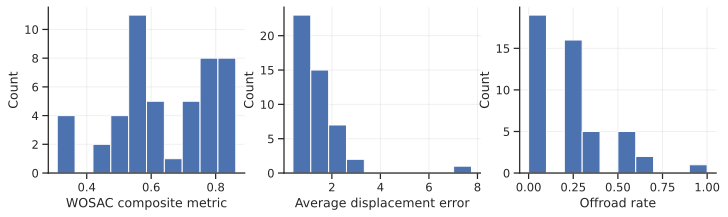

In [142]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

axs[0].hist(df_dist["metametric"], bins=10)
axs[0].set_ylabel("Count")
axs[0].set_xlabel("WOSAC composite metric")
axs[0].grid(True, alpha=.3)

axs[1].hist(df_dist["average_displacement_error"], bins=10)
axs[1].set_ylabel("Count")
axs[1].set_xlabel("Average displacement error")
axs[1].grid(True, alpha=.3)

axs[2].hist(df_dist["simulated_offroad_rate"], bins=10)
axs[2].set_ylabel("Count")
axs[2].set_xlabel("Offroad rate")
axs[2].grid(True, alpha=.3)

#sns.histplot(df_dist, x="metametric", bins=50, kde=False)

sns.despine()

<Axes: xlabel='metametric', ylabel='simulated_offroad_rate'>

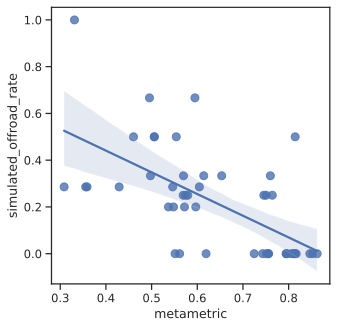

In [143]:
sns.regplot(data=df_dist, x='metametric', y='simulated_offroad_rate')

<Axes: xlabel='metametric', ylabel='average_displacement_error'>

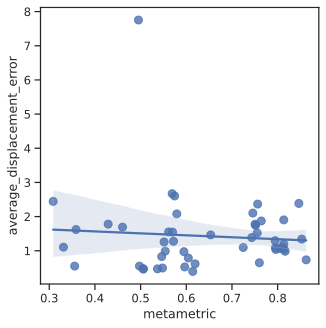

In [144]:
sns.regplot(data=df_dist, x='metametric', y='average_displacement_error')

<Axes: xlabel='metametric', ylabel='simulated_collision_rate'>

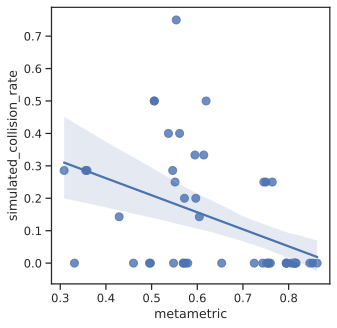

In [145]:
sns.regplot(data=df_dist, x='metametric', y='simulated_collision_rate')